In [3]:
import numpy as np
import torch
from scripts.utils import load_ply
from pytorch3d.structures import Meshes,Pointclouds
from pytorch3d.renderer import Textures
from pytorch3d.io import load_obj
from point_sam.build_model import build_point_sam
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pytorch3d.ops as ops
from pytorch3d.ops import sample_farthest_points
from utils.nms import apply_pointwise_nms,visualize_point_clouds_with_masks
from mask_proposal import  mask_proposal,mask_proposal_v2
from utils.render import render_all_angles_pc,render_single_view
import glob
# Use glob to access all files in the directory
from transformers import AutoProcessor, AutoModelForCausalLM
import random
import os
from utils.inference_florence import run_florence2
from PIL import Image
import cv2
import supervision as sv
from third_party.Ground_SAM.sam2.build_sam import build_sam2
from third_party.Ground_SAM.sam2.sam2_image_predictor import SAM2ImagePredictor
from third_party.Ground_SAM.mask_proposal_2d import segment2d
# os.chdir('/home/wan/Workplace-why/Point-SAM')

In [4]:
def normalize_point_cloud(xyz):
    """
    Normalize the point cloud by centering it and scaling it to fit within a unit sphere.
    :param xyz: The point cloud coordinates of shape (n_points, 3).
    :return: The normalized point cloud coordinates.
    """
    # Center the points by subtracting the mean
    centroid = np.mean(xyz, axis=0)
    xyz_centered = xyz - centroid

    # Scale the points to fit within a unit sphere
    furthest_distance = np.max(np.sqrt(np.sum(xyz_centered**2, axis=1)))
    xyz_normalized = xyz_centered / furthest_distance

    return xyz_normalized

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [6]:
from point_sam.build_model import build_point_sam
import numpy as np
import torch
from scripts.utils import load_ply
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures
from pytorch3d.io import load_obj


# Constants
# NUM_PROMPTS = 10
NUM_PROMPTS = 512
NUM_MASKS_PER_PROMPT = 3
NMS_THRESHOLD = 0.1
TOP_K_PROPOSALS = 250


In [7]:
#
SCENE_ID = 'scene0011_00'
prompt = 'I want to die'
scene_path = '/home/wan/Workplace-why/Point-SAM/assets/kitchen_ply/example_kitchen.ply'
labels=['/home/wan/Workplace-why/Point-SAM/assets/kitchen_ply/labels.txt']
target_class = 6

scene_pc = load_ply(scene_path)

with open(labels[0], 'rb') as f:
        mask =np.loadtxt(f)
        mask = (mask==target_class).astype(bool)
    
# use mask to index the target object
ckpt_path = "/home/wan/Workplace-why/Point-SAM/checkpoints/model.safetensors"
model = build_point_sam(ckpt_path, 512, 64).to(device)

target_mask = mask
obj_pc = scene_pc[target_mask]

obj_pc = obj_pc
obj_xyz = obj_pc[:, :3]
obj_xyz = normalize_point_cloud(obj_xyz)
obj_rgb = obj_pc[:, 3:6]
obj_xyz_tensor = torch.tensor(obj_xyz).cuda().float()  # (batch_size, n_points, 3)
obj_rgb_tensor = torch.tensor(obj_rgb).cuda().float()  # (batch_size, n_points, 3)
obj_pcd = Pointclouds(points=[obj_xyz_tensor], features=[obj_rgb_tensor])

obj_xyz_tensor = obj_xyz_tensor.unsqueeze(0)
obj_rgb_tensor = obj_rgb_tensor.unsqueeze(0)

In [8]:
top_k_masks,_,_ = mask_proposal(obj_xyz_tensor,obj_rgb_tensor,NUM_PROMPTS,model)

100%|██████████| 512/512 [00:01<00:00, 263.55it/s]


# Snap

In [9]:

img_dir, pc_depth, screen_coords, num_views, cameras = render_all_angles_pc(obj_pcd,'/home/wan/Workplace-why/Point-SAM/output/test_pc',device)

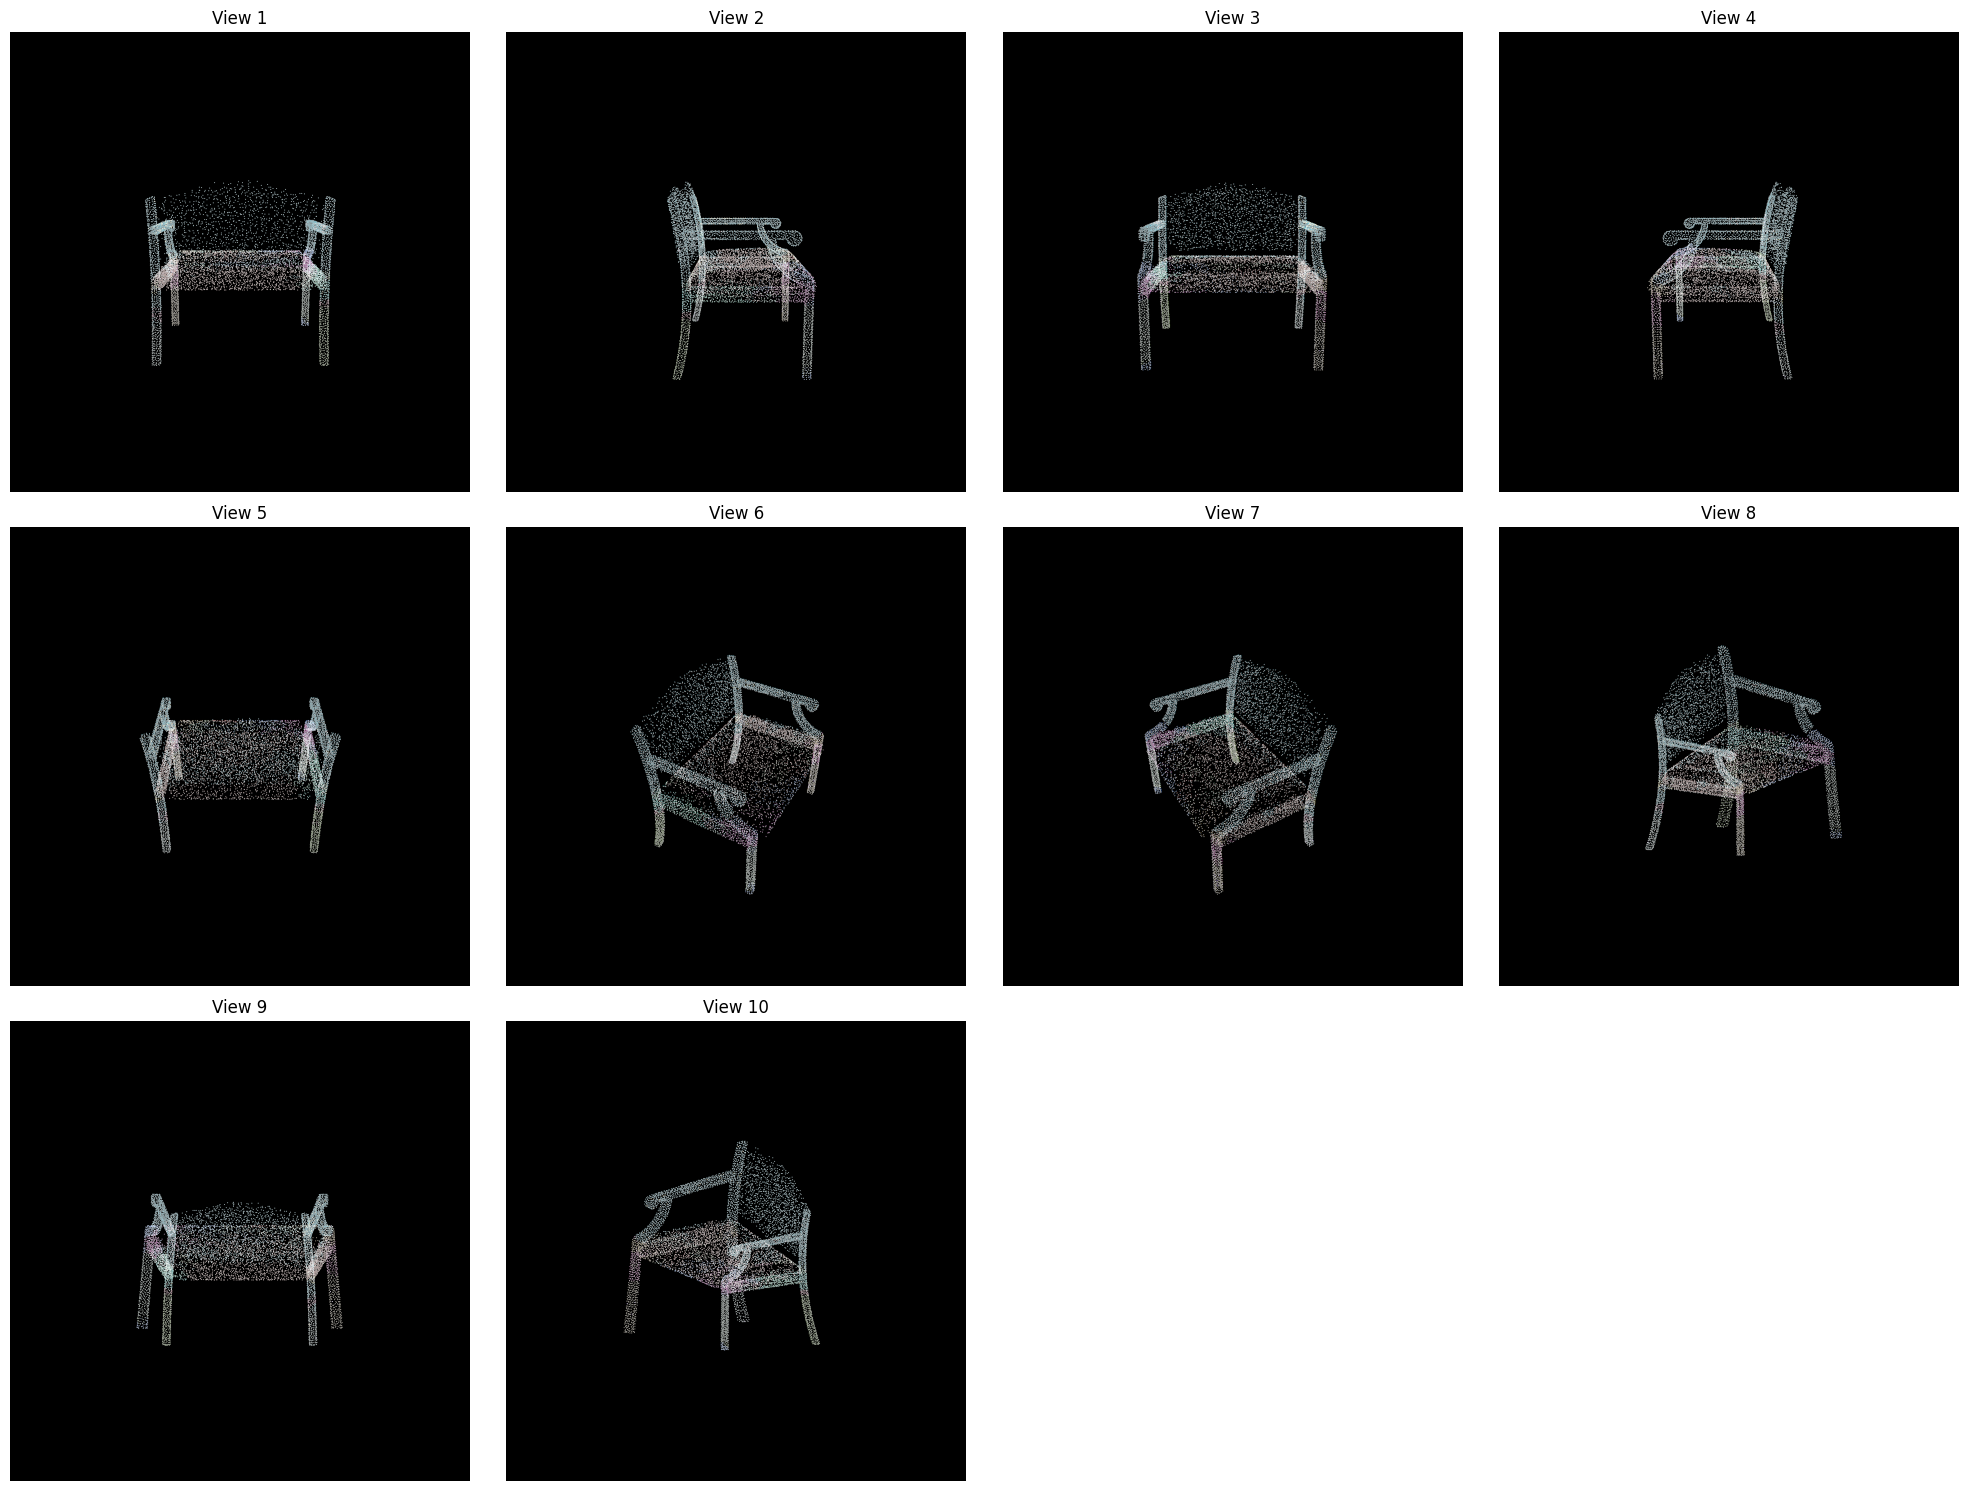

3D mask to 2D bounding box correspondences:
View 1:
  Mask 1: (np.int64(651), np.int64(528), np.int64(680), np.int64(543))
  Mask 2: (np.int64(301), np.int64(331), np.int64(724), np.int64(656))
  Mask 3: (np.int64(318), np.int64(373), np.int64(370), np.int64(499))
  Mask 4: (np.int64(637), np.int64(535), np.int64(704), np.int64(571))
  Mask 5: (np.int64(660), np.int64(427), np.int64(681), np.int64(464))
  Mask 6: (np.int64(316), np.int64(488), np.int64(680), np.int64(574))
  Mask 7: (np.int64(325), np.int64(560), np.int64(586), np.int64(573))
  Mask 8: (np.int64(351), np.int64(429), np.int64(351), np.int64(429))
  Mask 9: (np.int64(670), np.int64(517), np.int64(692), np.int64(553))
  Mask 10: (np.int64(636), np.int64(523), np.int64(653), np.int64(527))
  Mask 11: (np.int64(342), np.int64(542), np.int64(358), np.int64(555))
  Mask 12: (np.int64(354), np.int64(513), np.int64(354), np.int64(513))
  Mask 13: (np.int64(353), np.int64(487), np.int64(431), np.int64(528))
  Mask 15: (np.int64(

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import torch


def project_3d_to_2d(obj_xyz: np.ndarray, 
                     top_k_masks: np.ndarray, 
                     screen_coords: np.ndarray, 
                     pc_depth: np.ndarray, 
                     img_size: Tuple[int, int] = (1024, 1024)) -> Tuple[List[np.ndarray], Dict[int, Dict[int, Tuple[float, float, float, float]]], List[np.ndarray]]:
    width, height = img_size
    num_views = screen_coords.shape[0]
    
    if isinstance(top_k_masks, torch.Tensor):
        top_k_masks = top_k_masks.cpu().numpy()
    
    num_masks = 100  # Fixed number of masks
    colors = np.random.randint(0, 255, size=(num_masks, 3))
    
    mask_2d_bbox_correspondences = {view_idx: {} for view_idx in range(num_views)}
    mask2d_view_list = []
    binary_masks_list = []

    for view_idx in range(num_views):
        depth_buffer = np.full((height, width), np.inf)
        mask_2d_color_view = np.zeros((height, width, 3), dtype=np.uint8)
        binary_masks = np.zeros((num_masks, height, width), dtype=bool)
        
        view_screen_coords = screen_coords[view_idx]
        view_pc_depth = pc_depth[view_idx]
        
        for mask_idx in range(num_masks):
            if mask_idx < len(top_k_masks):
                mask_points = obj_xyz[top_k_masks[mask_idx]]
                mask_screen_coords = view_screen_coords[top_k_masks[mask_idx]]
                mask_depth = np.linalg.norm(mask_points, axis=1)
                
                valid_points = (mask_screen_coords[:, 0] >= 0) & (mask_screen_coords[:, 0] < width) & \
                               (mask_screen_coords[:, 1] >= 0) & (mask_screen_coords[:, 1] < height)
                
                valid_screen_coords = mask_screen_coords[valid_points].astype(int)
                valid_depths = mask_depth[valid_points]
                
                y, x = valid_screen_coords[:, 1], valid_screen_coords[:, 0]
                current_depths = depth_buffer[y, x]
                update_mask = valid_depths < current_depths
                
                if np.any(update_mask):
                    update_y, update_x = y[update_mask], x[update_mask]
                    depth_buffer[update_y, update_x] = valid_depths[update_mask]
                    mask_2d_color_view[update_y, update_x] = colors[mask_idx]
                    binary_masks[mask_idx, update_y, update_x] = True
                    
                    min_x, min_y = np.min(valid_screen_coords[update_mask], axis=0)
                    max_x, max_y = np.max(valid_screen_coords[update_mask], axis=0)
                    mask_2d_bbox_correspondences[view_idx][mask_idx] = (min_x, min_y, max_x, max_y)
        
        mask2d_view_list.append(mask_2d_color_view)
        binary_masks_list.append(binary_masks)
    
    return mask2d_view_list, mask_2d_bbox_correspondences, binary_masks_list

def visualize_projections(mask2d_view_list: List[np.ndarray], binary_masks_list: List[np.ndarray], num_cols: int = 4):
    num_views = len(mask2d_view_list)
    num_masks = binary_masks_list[0].shape[0]
    num_rows = (num_views + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    axes = axes.flatten()
    
    for i, (mask_2d_color_view, binary_masks) in enumerate(zip(mask2d_view_list, binary_masks_list)):
        axes[i].imshow(mask_2d_color_view)
        axes[i].set_title(f'View {i + 1}')
        axes[i].axis('off')
        
        # Overlay binary masks
        for mask_idx in range(num_masks):
            mask = binary_masks[mask_idx]
            if np.any(mask):  # Only draw contour if mask is not empty
                axes[i].contour(mask, colors=['white'], linewidths=0.5, alpha=0.5)
    
    for i in range(num_views, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution

mask2d_view_list, mask_2d_bbox_correspondences, binary_masks_list = project_3d_to_2d(obj_xyz, top_k_masks, screen_coords, pc_depth)

visualize_projections(mask2d_view_list, binary_masks_list)

print("3D mask to 2D bounding box correspondences:")
for view_idx, mask_dict in mask_2d_bbox_correspondences.items():
    print(f"View {view_idx + 1}:")
    for mask_idx, bbox in mask_dict.items():
        print(f"  Mask {mask_idx + 1}: {bbox}")

# If you want to access the binary mask for a specific view and mask:
view_index = 0  # Change this to the desired view index
mask_index = 0  # Change this to the desired mask index
specific_binary_mask = binary_masks_list[view_index][mask_index]
print(f"Shape of binary mask for View {view_index + 1}, Mask {mask_index + 1}: {specific_binary_mask.shape}")
print(f"Number of pixels in this mask: {np.sum(specific_binary_mask)}")

# Build look up dict

In [19]:
FLORENCE2_MODEL_ID = "microsoft/Florence-2-large"
SAM2_CHECKPOINT = "/home/wan/Workplace-why/Point-SAM/third_party/Ground_SAM/checkpoints/sam2_hiera_large.pt"
SAM2_CONFIG = "sam2_hiera_l.yaml"


torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32


# build florence-2
florence2_model = AutoModelForCausalLM.from_pretrained(FLORENCE2_MODEL_ID, trust_remote_code=True, torch_dtype='auto').eval().to(device)
florence2_processor = AutoProcessor.from_pretrained(FLORENCE2_MODEL_ID, trust_remote_code=True)


# build sam 2
sam2_model = build_sam2(SAM2_CONFIG, SAM2_CHECKPOINT, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

file_paths = glob.glob(os.path.join(img_dir, '*'))
points_3d =[]
visible_pts_list = []
# Print all the files found

task_prompt = "<OPEN_VOCABULARY_DETECTION>"
text_input = ["leg","seat","arm",'back']
# torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__(
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

save_dir = '/home/wan/Workplace-why/Point-SAM/output/test_pc'
result_dict = segment2d(num_views = num_views ,save_dir=save_dir,text_input=text_input,task_prompt=task_prompt,florence2_model=florence2_model,florence2_processor=florence2_processor,sam2_predictor= sam2_predictor)

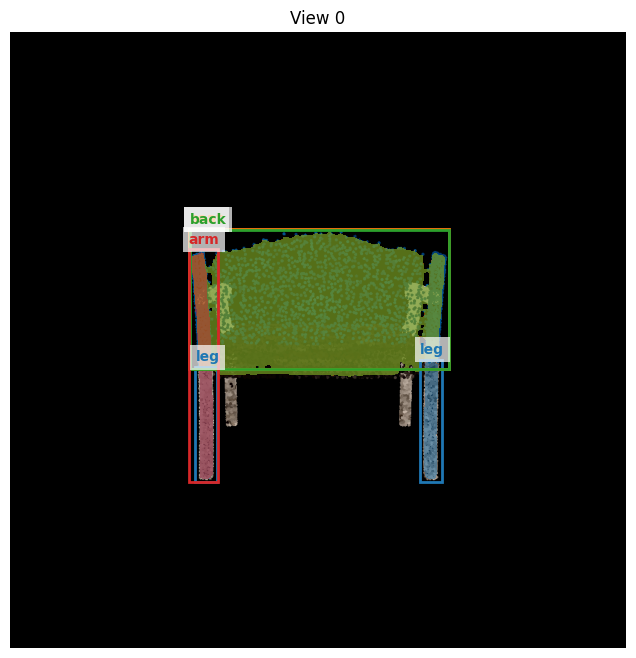

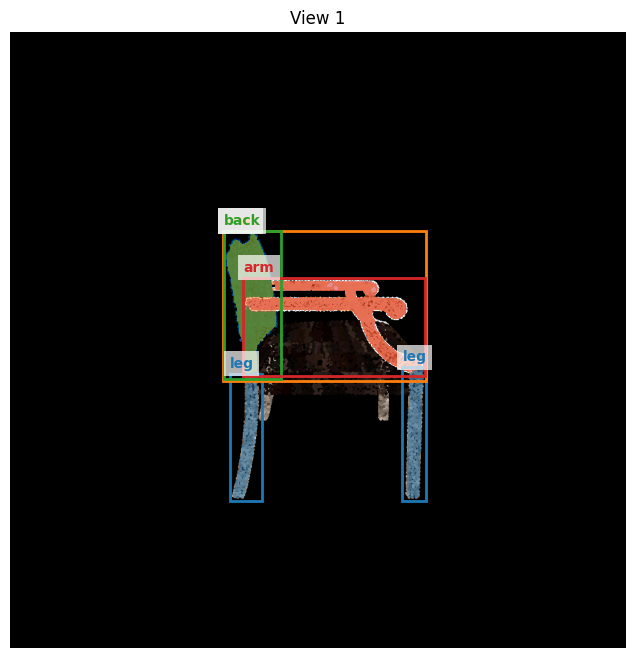

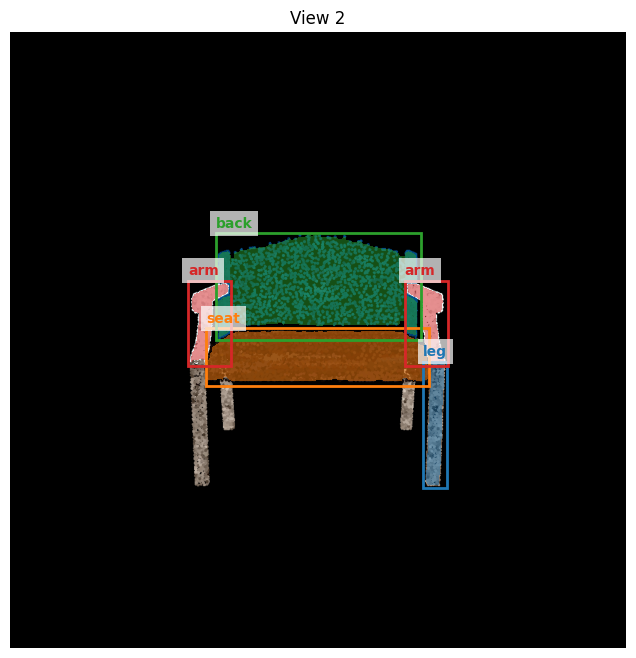

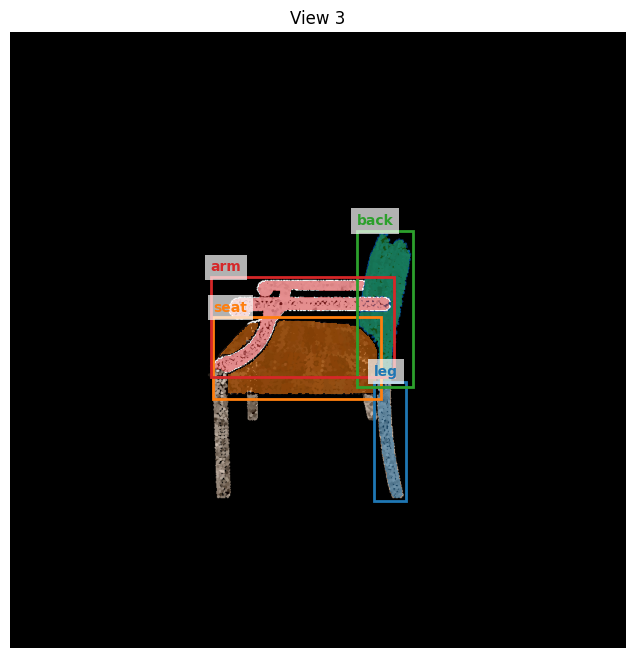

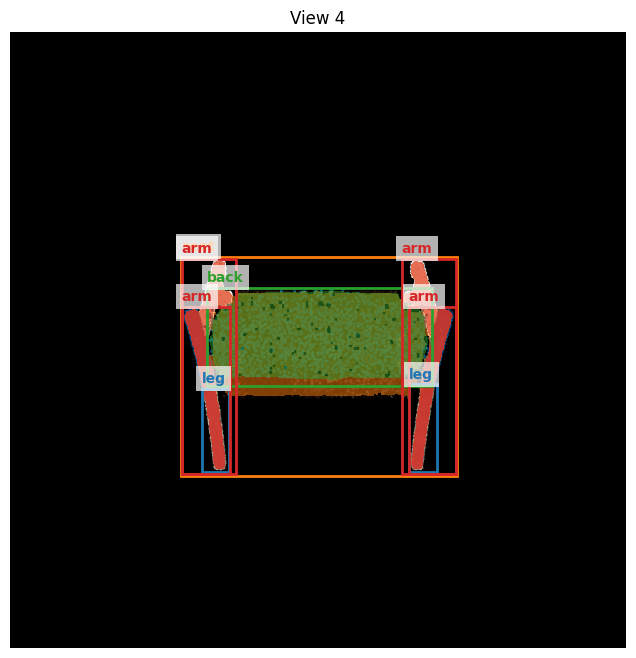

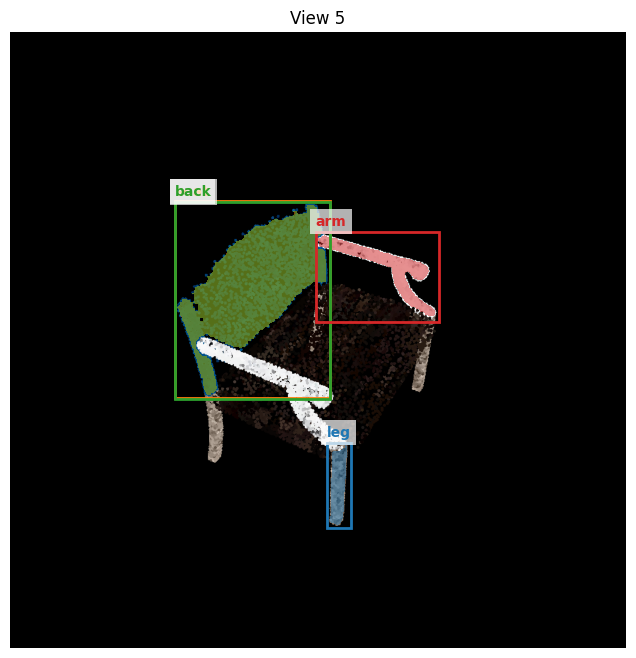

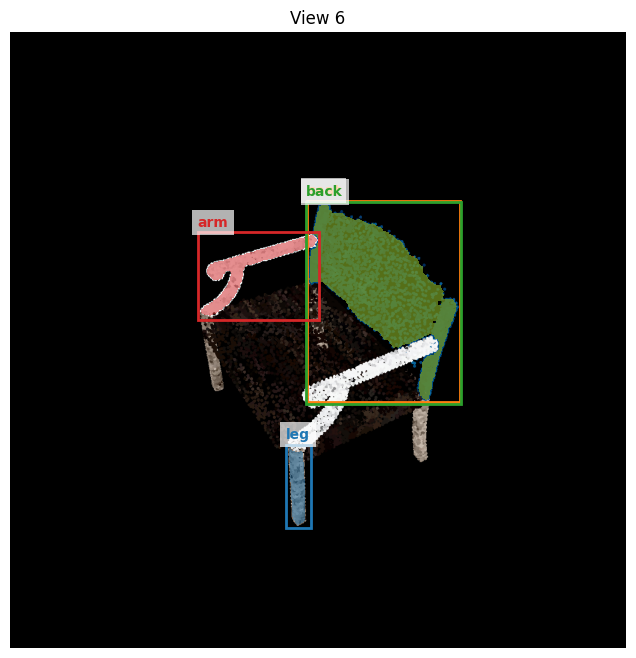

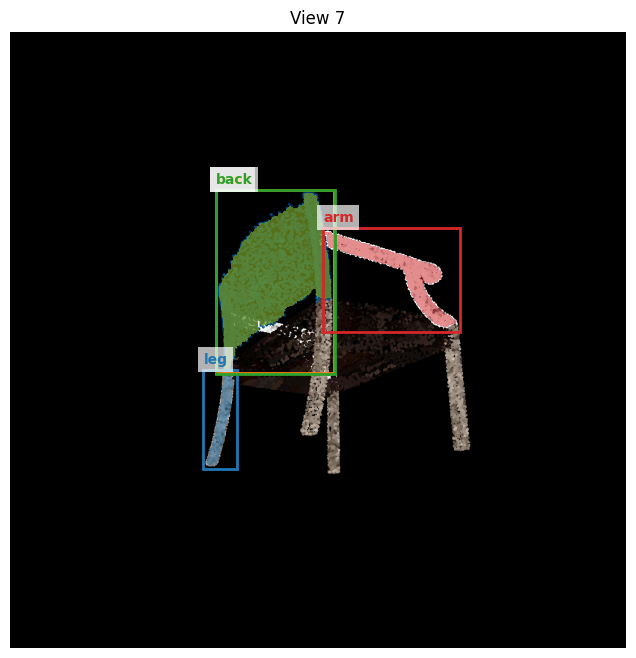

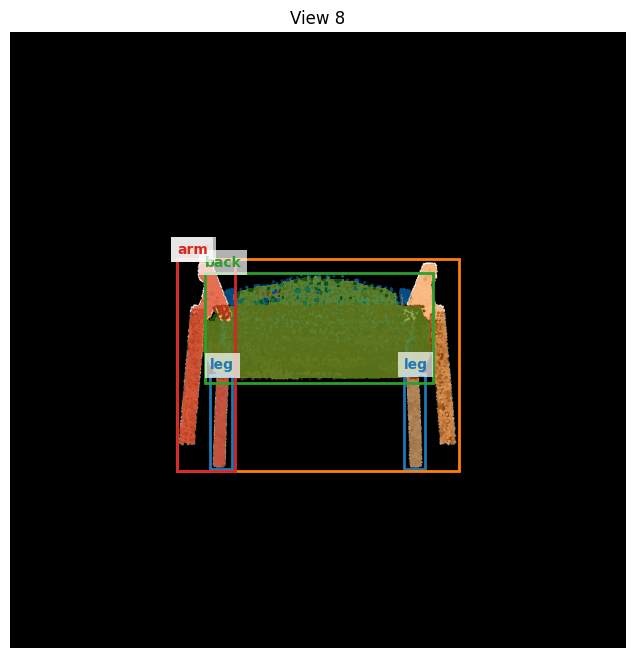

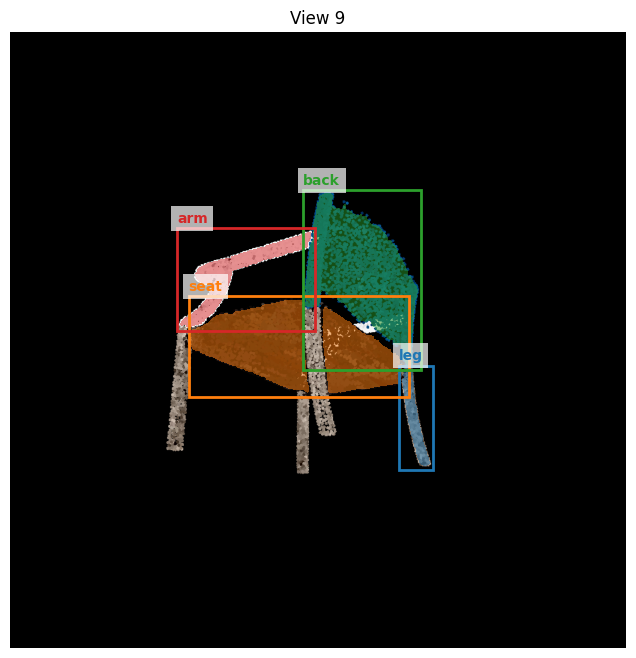

Visualization complete. Images saved in the sam_result directory.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

def visualize_sam_results(class_results, num_views, save_dir):
    # Create a color map for different classes
    colors = list(mcolors.TABLEAU_COLORS.values())
    class_color_map = {class_name: colors[i % len(colors)] for i, class_name in enumerate(class_results.keys())}

    for view_idx in range(num_views):
        fig, ax = plt.subplots(1, figsize=(12, 8))

        # Load and display the original image for this view
        image_path = f"{save_dir}/rendered_img/{view_idx}.png"
        original_image = plt.imread(image_path)
        ax.imshow(original_image)

        # Visualize masks and bounding boxes for each class
        for class_name, class_data in class_results.items():
            if view_idx < len(class_data['masks']):
                masks = class_data['masks'][view_idx]
                bboxes = class_data['bboxes'][view_idx]
                color = class_color_map[class_name]

                for mask, bbox in zip(masks, bboxes):
                    # Display the mask
                    ax.imshow(np.ma.masked_where(mask == False, mask), 
                              cmap=mcolors.ListedColormap([color]), 
                              alpha=0.5)

                    # Display the bounding box
                    min_x, min_y, max_x, max_y = bbox
                    rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                                             linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)

                    # Add label
                    ax.text(min_x, min_y - 10, class_name, color=color, 
                            fontsize=10, weight='bold', 
                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

        # Set the title for the current view
        ax.set_title(f'View {view_idx}')
        
        # Turn off axis for a cleaner image
        plt.axis('off')

        # Save the figure
        output_dir = f"{save_dir}/sam_result/"
        plt.savefig(f"{output_dir}/visualized_sam_result_{view_idx}.png", bbox_inches='tight', dpi=300)
        plt.show()  # Close the figure to free up memory

    print("Visualization complete. Images saved in the sam_result directory.")

# Usage:
visualize_sam_results(result_dict, num_views, save_dir)


# mask classification

In [22]:
def binaryMaskIOU(mask1, mask2):
    if isinstance(mask1, np.ndarray):
        mask1 = torch.from_numpy(mask1)
    if isinstance(mask2, np.ndarray):
        mask2 = torch.from_numpy(mask2)
    
    mask1_area = torch.count_nonzero(mask1)
    mask2_area = torch.count_nonzero(mask2)
    intersection = torch.count_nonzero(torch.logical_and(mask1, mask2))
    union = mask1_area + mask2_area - intersection
    iou = intersection.float() / union.float() if union > 0 else torch.tensor(0.0)
    return iou.item()

def binaryMaskIOU(mask1, mask2):
    if isinstance(mask1, np.ndarray):
        mask1 = torch.from_numpy(mask1)
    if isinstance(mask2, np.ndarray):
        mask2 = torch.from_numpy(mask2)

    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = torch.logical_or(mask1, mask2).to(torch.int).sum()
    return intersection / union

def process_masks_and_calculate_iou(
    class_results: Dict, 
    num_views: int, 
    binary_masks_list: List[np.ndarray], 
    iou_threshold: float = 0, 
    normalized_threshold: float = 0.2
) -> Dict:
    target_3d_masks = {class_name: {view_idx: [] for view_idx in range(num_views)} for class_name in class_results.keys()}

    for view_idx in range(num_views):
        binary_masks = binary_masks_list[view_idx]

        for class_name, class_data in class_results.items():
            if view_idx < len(class_data['masks']):
                sam_masks = class_data['masks'][view_idx]
                view_ious = []

                for mask_idx in range(len(binary_masks)):
                    for sam_mask_idx, sam_mask in enumerate(sam_masks):
                        # Calculate IoU for masks
                        mask_iou = binaryMaskIOU(binary_masks[mask_idx], sam_mask)
                        if mask_iou > 0:
                            view_ious.append((mask_idx, mask_iou))

                # Normalize IoU scores for this view and class using sum-based method
                if view_ious:
                    total_iou = sum(iou for _, iou in view_ious)
                    
                    if total_iou > normalized_threshold:
                        normalized_ious = [(mask_idx, iou / total_iou) for mask_idx, iou in view_ious]
                        
                        # Filter normalized IoUs based on the normalized threshold
                        filtered_ious = [(mask_idx, score) for mask_idx, score in normalized_ious if score >= normalized_threshold]
                        
                        target_3d_masks[class_name][view_idx] = filtered_ious

    return target_3d_masks



In [23]:




target_3d_masks = process_masks_and_calculate_iou(result_dict, num_views, binary_masks_list, 0,0.1)

# Normalize scores and rank masks
target_3d_masks


{'leg': {0: [(37, tensor(0.3243)), (44, tensor(0.2351))],
  1: [(32, tensor(0.3338)), (37, tensor(0.3042))],
  2: [(23, tensor(0.1335)),
   (44, tensor(0.1958)),
   (52, tensor(0.3098)),
   (68, tensor(0.2757))],
  3: [],
  4: [(31, tensor(0.1049)), (37, tensor(0.3681)), (44, tensor(0.2611))],
  5: [(32, tensor(0.6888)), (46, tensor(0.1385)), (90, tensor(0.1449))],
  6: [(44, tensor(0.2306)), (52, tensor(0.3666)), (68, tensor(0.3103))],
  7: [(1, tensor(0.1545)), (30, tensor(0.1233)), (44, tensor(0.5566))],
  8: [(37, tensor(0.4239)), (44, tensor(0.2727))],
  9: [(31, tensor(0.1868)), (37, tensor(0.6454))]},
 'seat': {0: [],
  1: [(1, tensor(0.8013))],
  2: [(1, tensor(0.1046)), (6, tensor(0.5366))],
  3: [(6, tensor(0.5209))],
  4: [(1, tensor(0.4423)), (6, tensor(0.2223))],
  5: [],
  6: [],
  7: [],
  8: [(1, tensor(0.4183)), (6, tensor(0.2253))],
  9: [(1, tensor(0.1747)), (6, tensor(0.4912))]},
 'arm': {0: [(1, tensor(0.5237)), (6, tensor(0.1135)), (44, tensor(0.2221))],
  1: [(1,

# Filter the mask

In [12]:
from collections import defaultdict

# Define the threshold for N views
N = 4# The minimum number of views a mask must appear in to be considered a prediction

# Dictionary to store how many views each 3D mask appears in
mask_occurrences = defaultdict(int)

# Iterate over all the views and count how many views each 3D mask appears in
for view_idx, mask_list_for_view in target_3d_masks.items():
    for mask_idx in mask_list_for_view:
        mask_occurrences[mask_idx] += 1

# Filter the masks that appear in more than N views
final_predictions = [mask_idx for mask_idx, count in mask_occurrences.items() if count > N-1]

# Now `final_predictions` contains the 3D mask indices that appear in more than N views
print(f"Final prediction masks: {final_predictions}")


Final prediction masks: []


In [168]:
from collections import defaultdict

def assign_labels_to_masks(class_results, target_3d_masks, num_views, N=1):
    # Dictionary to store mIoU for each mask-label combination
    mask_label_miou = defaultdict(lambda: defaultdict(float))

    # Dictionary to store how many views each 3D mask appears in for each label
    mask_occurrences = defaultdict(lambda: defaultdict(int))

    # Calculate mIoU and count occurrences
    for class_name, view_data in target_3d_masks.items():
        for view_idx, mask_list_for_view in view_data.items():
            for mask_idx, iou in mask_list_for_view:
                mask_label_miou[mask_idx][class_name] += iou
                mask_occurrences[mask_idx][class_name] += 1

    # Calculate average IoU (mIoU) for each mask-label combination
    for mask_idx in mask_label_miou:
        for class_name in mask_label_miou[mask_idx]:
            mask_label_miou[mask_idx][class_name] /= mask_occurrences[mask_idx][class_name]

    # Assign labels based on highest mIoU and N-view threshold
    final_predictions = {}
    for mask_idx in mask_label_miou:
        best_label = max(mask_label_miou[mask_idx], key=mask_label_miou[mask_idx].get)
        if mask_occurrences[mask_idx][best_label] >= N:
            final_predictions[mask_idx] = {
                'label': best_label,
                'miou': mask_label_miou[mask_idx][best_label],
                'views': mask_occurrences[mask_idx][best_label]
            }

    print(f"Final predictions:")
    for mask_idx, prediction in final_predictions.items():
        print(f"Mask {mask_idx}: Label={prediction['label']}, mIoU={prediction['miou']:.4f}, Views={prediction['views']}")

    return final_predictions

In [169]:
final_predictions = assign_labels_to_masks(result_dict, target_3d_masks, num_views, N=1)


Final predictions:
Mask 34: Label=leg, mIoU=0.4112, Views=5
Mask 46: Label=leg, mIoU=0.2812, Views=6
Mask 33: Label=leg, mIoU=0.5207, Views=2
Mask 22: Label=leg, mIoU=0.1318, Views=1
Mask 55: Label=leg, mIoU=0.3344, Views=2
Mask 69: Label=leg, mIoU=0.3080, Views=2
Mask 30: Label=leg, mIoU=0.1469, Views=2
Mask 47: Label=leg, mIoU=0.1342, Views=1
Mask 90: Label=leg, mIoU=0.1388, Views=1
Mask 3: Label=back, mIoU=0.5779, Views=4
Mask 26: Label=leg, mIoU=0.1094, Views=1
Mask 1: Label=arm, mIoU=0.5036, Views=7
Mask 13: Label=seat, mIoU=0.3025, Views=5


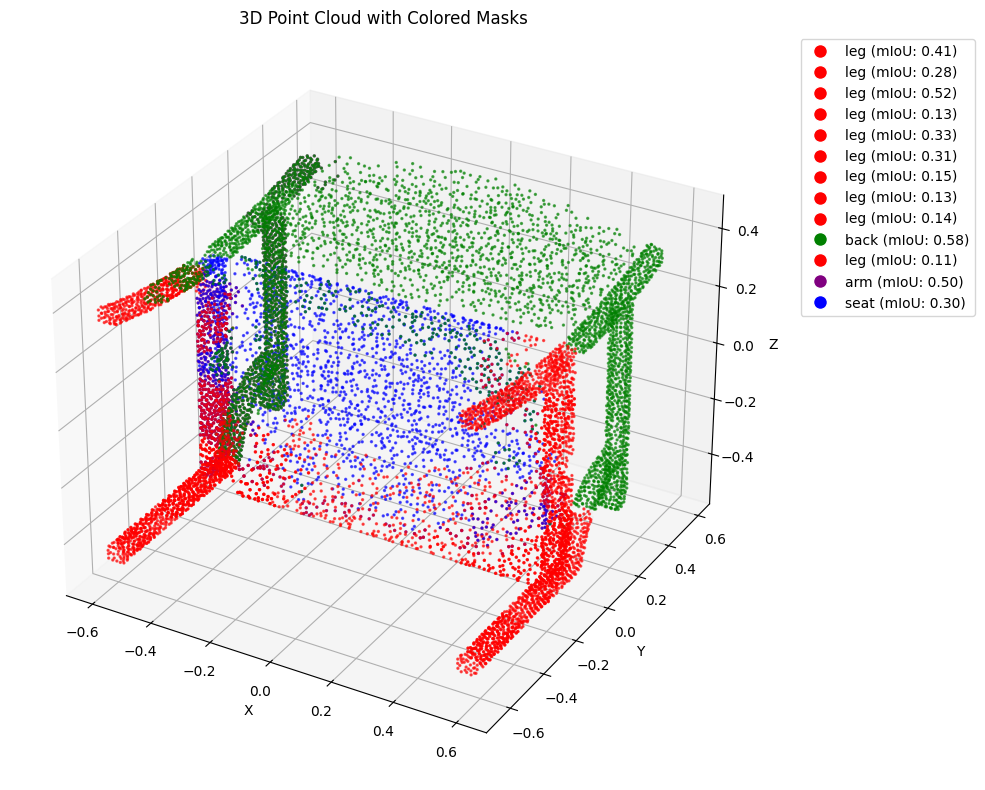

In [171]:
import open3d as o3d
import numpy as np
import torch
import random

def visualize_masks(obj_xyz, top_k_masks, mask_results):
    # Initialize the point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(obj_xyz)

    # Initialize a color array for the point cloud, all points will start as white
    colors = np.ones_like(obj_xyz)

    # Convert top_k_masks to numpy if it's a torch tensor
    if isinstance(top_k_masks, torch.Tensor):
        top_k_masks = top_k_masks.cpu().numpy()

    # Create a color map for labels
    label_colors = {
        'leg': [1, 0, 0],    # Red
        'back': [0, 1, 0],   # Green
        'seat': [0, 0, 1],   # Blue
    }

    # Iterate over the mask results and assign colors to the masked parts
    for mask_idx, mask_info in mask_results.items():
        # Extract the mask (boolean array) for the current mask index
        mask = top_k_masks[mask_idx]

        # Get the color for this label
        label = mask_info['label']
        base_color = label_colors.get(label, [random.random(), random.random(), random.random()])

        # Modify the color based on the mIoU score
        miou = mask_info['miou'].item()  # Convert tensor to float
        color = [c * miou for c in base_color]  # Darker color for lower mIoU

        # Apply the color to the points in the mask
        colors[mask] = color

    # Assign the colors to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Visualize the colored point cloud
    o3d.visualization.draw_plotly([pcd])

def visualize_masks_matplotlib(obj_xyz, top_k_masks, mask_results):
    # Convert top_k_masks to numpy if it's a torch tensor
    if isinstance(top_k_masks, torch.Tensor):
        top_k_masks = top_k_masks.cpu().numpy()

    # Create a color map for labels
    label_colors = {
        'leg': 'red',
        'back': 'green',
        'seat': 'blue',
    }

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot unmasked points in light gray
    unmasked = np.ones(top_k_masks.shape[1], dtype=bool)
    for mask in top_k_masks:
        unmasked = np.logical_and(unmasked, ~mask)
    ax.scatter(obj_xyz[unmasked, 0], obj_xyz[unmasked, 1], obj_xyz[unmasked, 2], c='lightgray', s=1, alpha=0.1)

    # Plot each mask
    legend_elements = []
    for mask_idx, mask_info in mask_results.items():
        mask = top_k_masks[mask_idx]
        label = mask_info['label']
        miou = mask_info['miou'].item()
        color = label_colors.get(label, 'purple')  # Default to purple if label not found
        
        scatter = ax.scatter(obj_xyz[mask, 0], obj_xyz[mask, 1], obj_xyz[mask, 2], 
                             c=color, s=2, alpha=0.6)
        
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                               label=f'{label} (mIoU: {miou:.2f})', 
                               markerfacecolor=color, markersize=10))

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point Cloud with Colored Masks')

    # Add legend
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Show the plot
    plt.show()


# Example usage:
visualize_masks_matplotlib(obj_xyz, top_k_masks, final_predictions)


# Map back to the scene

In [31]:
SCENE_ID = 'scene0011_00'
prompt = 'I want to die'
scene_path = '/home/wan/Workplace-why/Point-SAM/assets/kitchen_ply/example_kitchen.ply'
labels=['/home/wan/Workplace-why/Point-SAM/assets/kitchen_ply/labels.txt']
target_class = 8

scene_pc = load_ply(scene_path)

with open(labels[0], 'rb') as f:
        mask =np.loadtxt(f)
        mask = (mask==target_class).astype(bool)
    
# use mask to index the target object

target_mask = mask
obj_pc = scene_pc[target_mask]



obj_xyz = obj_pc[:, :3]
obj_xyz = normalize_point_cloud(obj_xyz)
obj_rgb = obj_pc[:, 3:6]

: 

In [1]:
scene_pcd = o3d.geometry.PointCloud()

# Assign the scene's point cloud data (xyz and rgb)
scene_pcd.points = o3d.utility.Vector3dVector(scene_pc[:, :3])
scene_pcd.colors = o3d.utility.Vector3dVector(scene_pc[:, 3:6])

# Step 2: Color the masked part of the object in red
colored_obj_rgb = np.copy(obj_rgb)  # Make a copy of the object's colors
colored_obj_rgb[combined_mask] = [1, 0, 0]  # Color the masked part red

# Step 3: Replace the original object points in the scene with the colored ones
# Get the indices of the object in the scene using `target_mask`
scene_pc[target_mask, 3:6] = colored_obj_rgb  # Replace the RGB values of the object in the scene

# Step 4: Update the scene point cloud with the new colors
scene_pcd.colors = o3d.utility.Vector3dVector(scene_pc[:, 3:6])

# Step 5: Visualize the updated scene with the colored object


: 

In [ ]:
sce